# Sentiment Analysis and Topic Modeling for Yelp Business Success
# Author: Farzam Afzal
## Editor: Jennifer Nguyen

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

# NLP libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis

# BERT Sentiment Analysis
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from scipy.special import softmax

In [27]:
# Downloading necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Setting paths for data files
review_path = 'yelp_academic_dataset_review.json'  # Update with actual path
business_path = 'yelp_academic_dataset_business.json'  # Update with actual path

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JenNg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JenNg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JenNg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
# Function for reading JSON files line by line
def read_json(file_path, max_records=None):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f)):
            if max_records and i >= max_records:
                break
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Loading a sample of review data for development (adjust max_records for full implementation)
print("Loading review data...")
review_df = read_json(review_path, max_records=50000)  # May use a larger sample for actual implementation
print(f"Loaded {len(review_df)} reviews.")

# Load business data to join with reviews
print("Loading business data...")
business_df = read_json(business_path)
print(f"Loaded {len(business_df)} businesses.")

Loading review data...


50000it [00:00, 214092.32it/s]


Loaded 50000 reviews.
Loading business data...


150346it [00:01, 107608.38it/s]


Loaded 150346 businesses.


In [29]:
# Joining business categories with reviews for context-aware analysis
review_business_df = review_df.merge(
    business_df[['business_id', 'categories']], 
    on='business_id', 
    how='left'
)

#--------------------------------------------------
# Text Preprocessing Functions
#--------------------------------------------------

In [30]:
def preprocess_text(text):
    """Clean and normalize text data for NLP tasks."""
    if not isinstance(text, str):
        return ""
    
    # Conversion to lowercase
    text = text.lower()
    
    # Removal of HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Removal of URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Removal of special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Removal of extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def tokenize_and_lemmatize(text):
    """Tokenize and lemmatize text."""
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Removing stopwords and lemmatizing
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return tokens

#--------------------------------------------------
# BERT-based Sentiment Analysis
#--------------------------------------------------

In [31]:
class BERTSentimentAnalyzer:
    def __init__(self):
        # Load pre-trained BERT model for sentiment analysis
        self.tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
        self.model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
        self.sentiment_pipeline = pipeline("sentiment-analysis", 
                                           model=self.model, 
                                           tokenizer=self.tokenizer)
        
    def analyze_sentiment(self, text, max_length=512):
        """
        Analyze sentiment of text using BERT.
        Returns:
            - sentiment_score: Normalized score between 0 and 1
            - sentiment_label: One of 'negative', 'neutral', or 'positive'
        """
        # Truncates text to max_length
        text = text[:max_length]
        
        # Gets sentiment prediction
        result = self.sentiment_pipeline(text)[0]
        
        # Extracts label and score
        raw_score = int(result['label'].split(' ')[0])
        
        # Normalizes to 0-1 range (model returns scores 1-5)
        normalized_score = (raw_score - 1) / 4
        
        # Determines sentiment label
        if normalized_score < 0.4:
            sentiment_label = 'negative'
        elif normalized_score > 0.6:
            sentiment_label = 'positive'
        else:
            sentiment_label = 'neutral'
            
        return normalized_score, sentiment_label
    
    def analyze_batch(self, texts, batch_size=32):
        """Analyze sentiment for a batch of texts."""
        sentiment_scores = []
        sentiment_labels = []
        
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            results = []
            
            for text in tqdm(batch, desc=f"Processing batch {i//batch_size + 1}"):
                if isinstance(text, str) and len(text.strip()) > 0:
                    score, label = self.analyze_sentiment(text)
                else:
                    score, label = 0.5, 'neutral'  # Default for empty text
                
                results.append((score, label))
            
            batch_scores, batch_labels = zip(*results)
            sentiment_scores.extend(batch_scores)
            sentiment_labels.extend(batch_labels)
        
        return sentiment_scores, sentiment_labels

#--------------------------------------------------
# Topic Modeling with LDA
#--------------------------------------------------

In [32]:
class ReviewTopicModeler:
    def __init__(self, n_topics=10, max_features=5000, min_df=5, max_df=0.8):
        self.n_topics = n_topics
        self.max_features = max_features
        self.min_df = min_df
        self.max_df = max_df
        
        # Initializes vectorizer
        self.vectorizer = CountVectorizer(
            max_features=max_features,
            min_df=min_df,
            max_df=max_df,
            stop_words='english'
        )
        
        # Initializes LDA model
        self.lda_model = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            max_iter=10,
            learning_method='online'
        )
        
        self.feature_names = None
        self.document_topics = None
        
    def fit_transform(self, texts):
        """Fit LDA model and transform texts to topic distributions."""
        # Creates document-term matrix
        print("Creating document-term matrix...")
        dtm = self.vectorizer.fit_transform(texts)
        self.feature_names = self.vectorizer.get_feature_names_out()
        self.texts = texts  # Store the texts as an instance variable
        
        # Fits LDA model
        print(f"Fitting LDA model with {self.n_topics} topics...")
        self.document_topics = self.lda_model.fit_transform(dtm)
        
        return self.document_topics
    
    def transform(self, texts):
        """Transform new texts to topic distributions."""
        dtm = self.vectorizer.transform(texts)
        return self.lda_model.transform(dtm)
    
    def get_topic_words(self, n_words=10):
        """Get the top words for each topic."""
        topic_words = []
        
        for topic_idx, topic in enumerate(self.lda_model.components_):
            top_word_indices = topic.argsort()[:-n_words-1:-1]
            top_words = [self.feature_names[i] for i in top_word_indices]
            topic_words.append(top_words)
            
        return topic_words
    
    def visualize_topics(self, dtm=None):
        """Create an interactive visualization of topics."""
        if dtm is None and hasattr(self, 'texts'):
            # Uses the document-term matrix from fit_transform
            dtm = self.vectorizer.transform(self.texts)
        elif dtm is None:
            print("Error: No texts available for visualization")
            return None
        
        # Convert the LDA model to the format required by pyLDAvis
        topic_term_dists = self.lda_model.components_ / self.lda_model.components_.sum(axis=1)[:, np.newaxis]
        doc_topic_dists = self.document_topics
        vocab = self.vectorizer.get_feature_names_out()
        term_frequency = np.asarray(dtm.sum(axis=0)).ravel()
        
        # Calculate document lengths (sum of term frequencies for each document)
        doc_lengths = np.asarray(dtm.sum(axis=1)).ravel()
        
        # Use the prepare function with all required parameters
        vis_data = pyLDAvis.prepare(
            topic_term_dists=topic_term_dists,
            doc_topic_dists=doc_topic_dists,
            doc_lengths=doc_lengths,
            vocab=vocab,
            term_frequency=term_frequency,
            mds='tsne'
        )
        
        # Saves visualization to HTML
        pyLDAvis.save_html(vis_data, 'lda_visualization.html')
        print("Visualization saved to 'lda_visualization.html'")
        
        return vis_data

#--------------------------------------------------
# Main Analysis Pipeline
#--------------------------------------------------

Sampling 10000 reviews for analysis...
Preprocessing review text...
After preprocessing, 9997 reviews remain.
Initializing BERT sentiment analyzer...


Device set to use cpu


Analyzing sentiment...


Processing batch 313: 100%|██████████| 13/13 [00:00<00:00, 15.67it/s]


Initializing topic modeler...
Creating document-term matrix...
Fitting LDA model with 10 topics...

Topic Keywords:
Topic 0: great, room, staff, hotel, car, nice, new, stay, time, clean, friendly, work, day, service, job
Topic 1: great, good, food, place, burger, service, delicious, cheese, really, chicken, fries, shrimp, pork, definitely, beer
Topic 2: bar, place, like, coffee, wine, just, really, fun, area, beer, parking, people, music, good, selection
Topic 3: time, drive, location, cafe, paid, kids, view, pool, healthy, available, delivery, floor, takes, play, located
Topic 4: ordered, time, food, just, order, came, got, like, didnt, table, sandwich, wasnt, good, wait, chicken
Topic 5: food, good, place, service, great, restaurant, nice, pretty, breakfast, really, staff, friendly, little, like, price
Topic 6: cream, ice, delicious, chocolate, amazing, sweet, tea, cake, bread, try, fresh, coffee, new, dessert, best
Topic 7: pizza, place, like, good, love, fresh, sushi, rice, im, chi

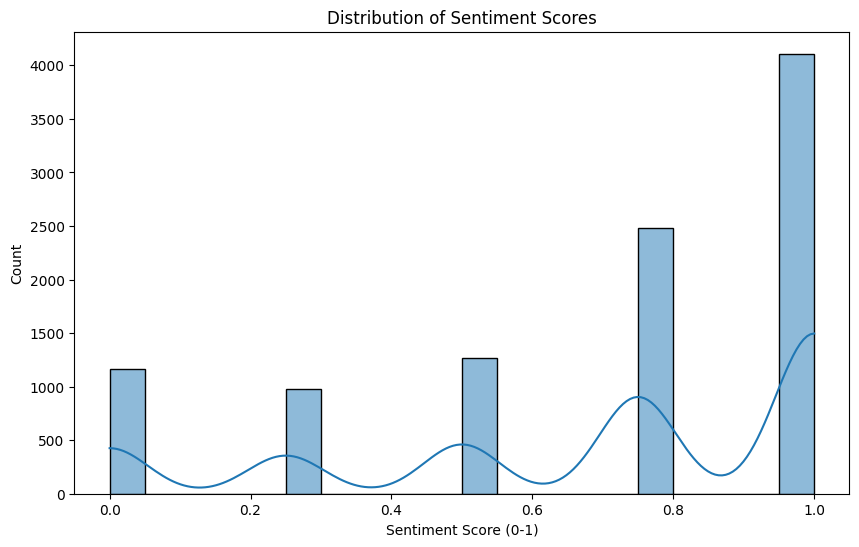

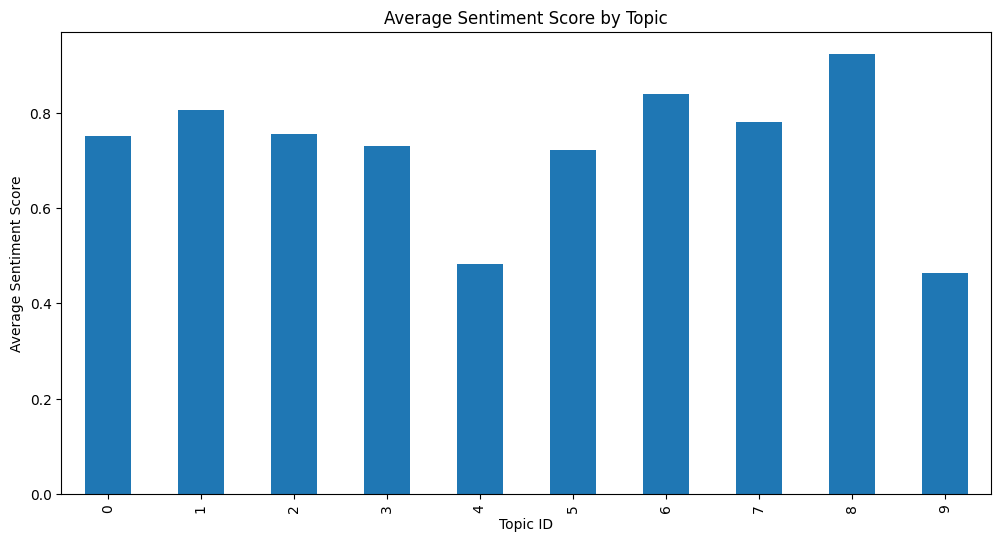

In [ ]:
def main():
    # Sampling a subset of reviews for development
    sample_size = 10000
    print(f"Sampling {sample_size} reviews for analysis...")
    review_sample = review_business_df.sample(sample_size, random_state=42)
    
    # Preprocessing review text
    print("Preprocessing review text...")
    review_sample['processed_text'] = review_sample['text'].apply(preprocess_text)
    
    # Filters out empty reviews after preprocessing
    review_sample = review_sample[review_sample['processed_text'].str.len() > 20]
    print(f"After preprocessing, {len(review_sample)} reviews remain.")
    
    # Initializes BERT sentiment analyzer
    print("Initializing BERT sentiment analyzer...")
    sentiment_analyzer = BERTSentimentAnalyzer()
    
    # Analyzes sentiment for reviews
    print("Analyzing sentiment...")
    sentiment_scores, sentiment_labels = sentiment_analyzer.analyze_batch(
        review_sample['processed_text'].tolist()
    )
    
    # Adds sentiment analysis results to dataframe
    review_sample['sentiment_score'] = sentiment_scores
    review_sample['sentiment_label'] = sentiment_labels
    
    # Initializes topic modeler
    print("Initializing topic modeler...")
    topic_modeler = ReviewTopicModeler(n_topics=10)
    
    # Fits topic model and get topic distributions
    topic_distributions = topic_modeler.fit_transform(review_sample['processed_text'])
    
    # Adds dominant topic for each review
    dominant_topics = np.argmax(topic_distributions, axis=1)
    review_sample['dominant_topic'] = dominant_topics
    
    # Gets top words for each topic
    topic_words = topic_modeler.get_topic_words(n_words=15)
    
    # Prints topic keywords
    print("\nTopic Keywords:")
    for i, words in enumerate(topic_words):
        print(f"Topic {i}: {', '.join(words)}")
        
    # Analyzes relationship between sentiment and topics
    topic_sentiment = review_sample.groupby('dominant_topic')['sentiment_score'].mean()
    
    print("\nAverage Sentiment Score by Topic:")
    print(topic_sentiment)
    
    # Analyzes relationship between topics and business stars
    topic_stars = review_sample.groupby('dominant_topic')['stars'].mean()
    
    print("\nAverage Star Rating by Topic:")
    print(topic_stars)
    
    # Saves processed data for further analysis
    print("Saving processed data...")
    review_sample.to_csv('processed_reviews_with_nlp.csv', index=False)
    
    # Creates sentiment score distribution by business
    business_sentiment = review_sample.groupby('business_id')['sentiment_score'].agg(['mean', 'median', 'count'])
    business_sentiment = business_sentiment.rename(columns={'mean': 'avg_sentiment', 'count': 'review_count'})
    
    # Merges with business data
    business_nlp_df = business_df.merge(business_sentiment, on='business_id', how='inner')
    
    # Saves business-level sentiment data
    business_nlp_df.to_csv('business_sentiment_data.csv', index=False)
    
    print("Analysis complete. Results saved to CSV files.")
    
    # Creates visualizations
    plt.figure(figsize=(10, 6))
    sns.histplot(review_sample['sentiment_score'], bins=20, kde=True)
    plt.title('Distribution of Sentiment Scores')
    plt.xlabel('Sentiment Score (0-1)')
    plt.ylabel('Count')
    plt.savefig('sentiment_distribution.png')
    
    # Topic-Sentiment relationship visualization
    plt.figure(figsize=(12, 6))
    topic_sentiment.plot(kind='bar')
    plt.title('Average Sentiment Score by Topic')
    plt.xlabel('Topic ID')
    plt.ylabel('Average Sentiment Score')
    plt.savefig('topic_sentiment.png')
    
    # Generating interactive LDA visualization
    topic_modeler.visualize_topics()

if __name__ == "__main__":
    main()